# Implementation Convolutional Bayesian Denoising Autoencoder Alzheimer MRI Scan Dataset


## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from skimage.metrics import structural_similarity as ssim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

image_size = 128

class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpeg') or fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        image.draft('L', (image_size, image_size))

        if self.transform:
            image = self.transform(image)

        # If you have labels, modify this part to return the corresponding label as well.
        return (image, 0)

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/mri_dataset'

# Define any transformations (e.g., normalization, resizing)
transform = transforms.Compose([
    # transforms.Resize((image_size, image_size)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create an instance of the dataset
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

print(len(xray_dataset))

# Split dataset into train/validation/test sets
train_indices, temp_indices = train_test_split(np.arange(len(xray_dataset)), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create data loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = DataLoader(xray_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(xray_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(xray_dataset, batch_size=64, sampler=test_sampler)

# Checking dataset sizes
print(f'Training dataset size: {len(train_sampler)}')
print(f'Validation dataset size: {len(val_sampler)}')
print(f'Test dataset size: {len(test_sampler)}')

print(len(train_loader))


6400
Training dataset size: 4480
Validation dataset size: 960
Test dataset size: 960
70


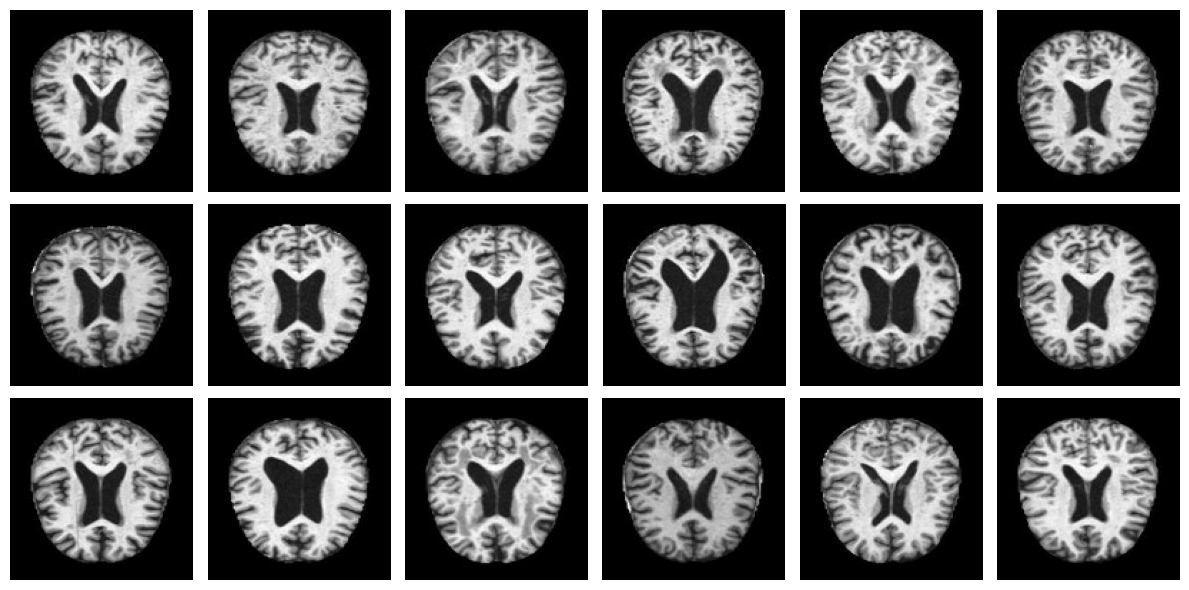

In [9]:
def plot_dataset(dataset):

  # Prepare to plot 3 rows of 6 images
  fig, axes = plt.subplots(3, 6, figsize=(12, 6))
  axes = axes.flatten()

  # Iterate through a few images from the dataset
  for i in range(18):  # Plotting 3 rows of 6 images
      image, label = dataset[i]
      image = image.squeeze().numpy()  # Convert tensor to numpy array and remove single-dimensional entries

      # Plot the image
      axes[i].imshow(image, cmap='gray')
      # axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

plot_dataset(xray_dataset)

In [12]:

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
mnist_dataset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)

# load the training and test datasets
fashion_dataset = datasets.FashionMNIST(root='data', train=True,
                                      download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21610839.62it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 622860.06it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5590198.24it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1454794.10it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 14157110.90it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 226646.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4239469.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4375334.75it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



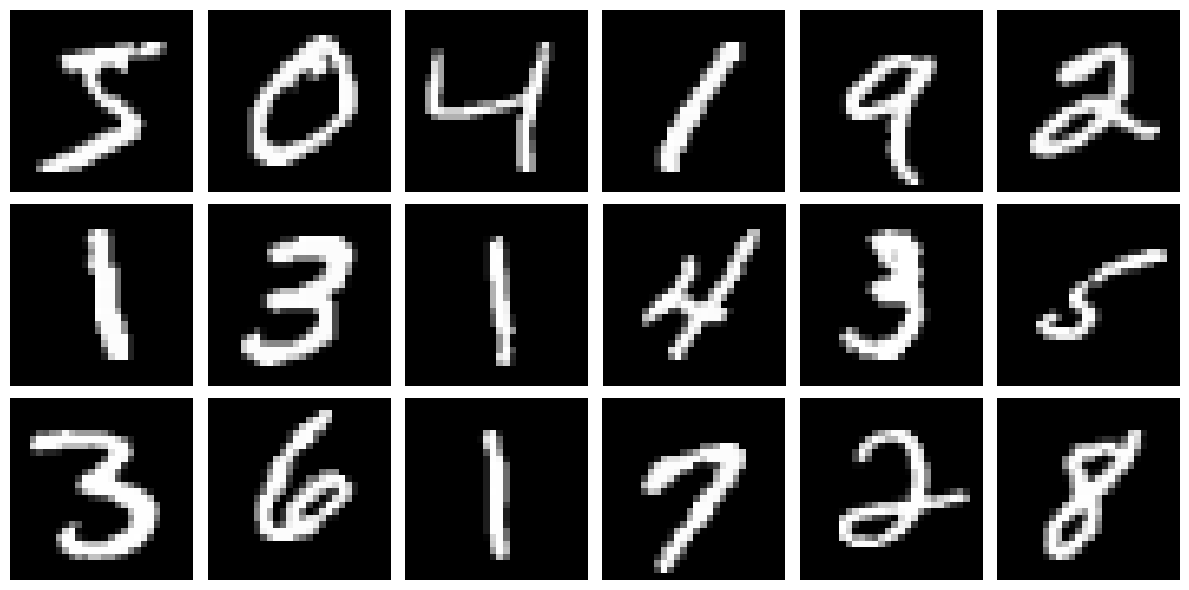

In [13]:
plot_dataset(mnist_dataset)

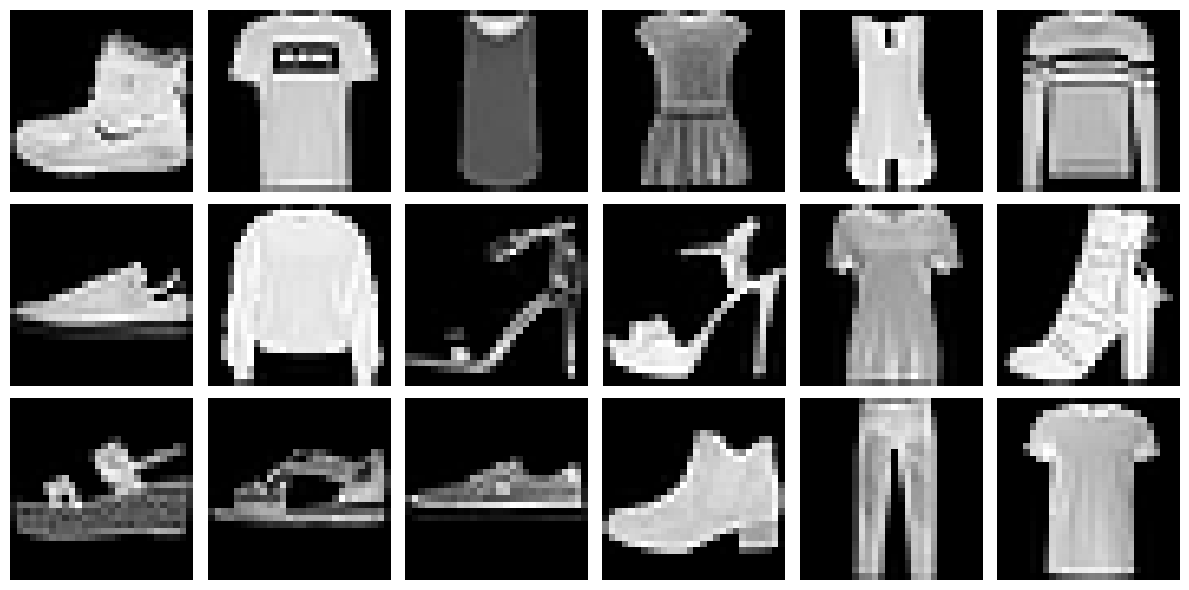

In [14]:
plot_dataset(fashion_dataset)

In [15]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

In [16]:
def get_image_row(dataset, start_index, num_images=3):
    images = []
    for i in range(num_images):
        image, _ = dataset[start_index + i]
        images.append(image)
    return images

# Assuming you want to plot the first row of images
start_index_mnist = 0
start_index_fashion = 0
start_index_xray = 0

mnist_images = get_image_row(mnist_dataset, start_index_mnist)
fashion_images = get_image_row(fashion_dataset, start_index_fashion)
xray_images = get_image_row(xray_dataset, start_index_xray)

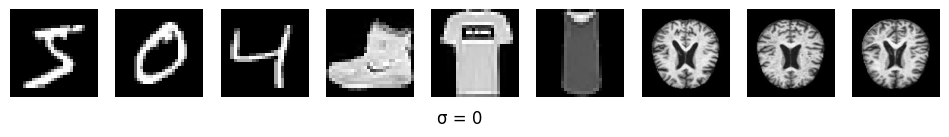

In [62]:
def plot_row(mnist_images, fashion_images, xray_images, noise_factor):
    plt.figure(figsize=(12, 4))

    # Plot MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 1)
        noisy_image = add_gaussian_noise(mnist_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('MNIST')
        plt.axis('off')

    # Plot Fashion MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 4)
        noisy_image = add_gaussian_noise(fashion_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('Fashion MNIST')
        plt.axis('off')

    # Plot X-ray images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 7)
        noisy_image = add_gaussian_noise(xray_images[i].view(1, 128, 128), noise_factor)
        plt.imshow(noisy_image.view(128, 128), cmap='gray')
        # plt.title('X-ray')
        plt.axis('off')

    # Add caption with noise_factor value
    plt.figtext(0.5, 0.32, f"σ = {noise_factor}", ha='center', fontsize=12)

    # plt.tight_layout(pad=0.1)  # Adjust padding between plot and figure edges
    plt.show()

plot_row(mnist_images, fashion_images, xray_images, 0)

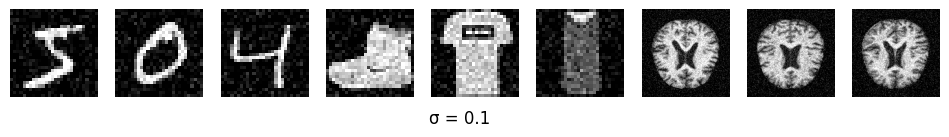

In [63]:

plot_row(mnist_images, fashion_images, xray_images, 0.1)

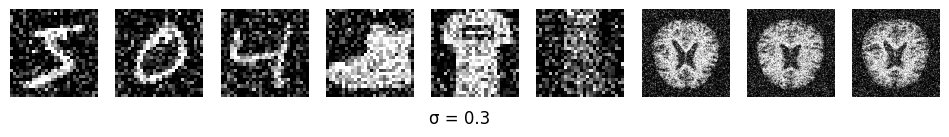

In [64]:
plot_row(mnist_images, fashion_images, xray_images, 0.3)

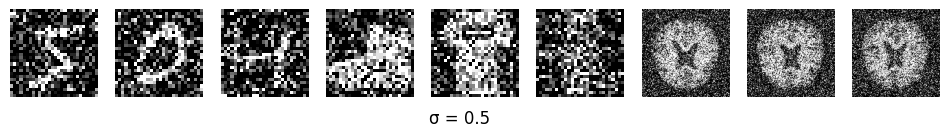

In [65]:
plot_row(mnist_images, fashion_images, xray_images, 0.5)

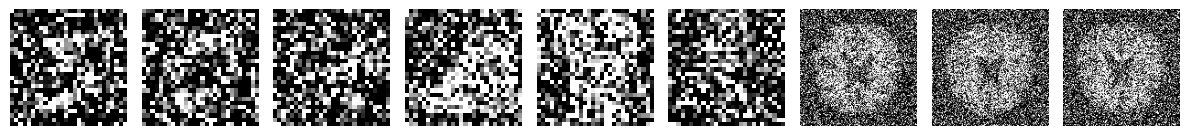

In [35]:

plot_row(mnist_images, fashion_images, xray_images, 0.8)